# BrightPath Academy: Student Performance Analysis

## Guided Project for MLG382 - 2025
### Predicting student performance to enable early interventions at BrightPath Academy

This notebook follows the guided project outline to analyze student performance data, build predictive models, and deploy a Dash application for BrightPath Academy. The goal is to address challenges in identifying at-risk students, tailoring interventions, and understanding the impact of extracurricular activities.


## 1. Problem Statement

<div style="padding: 15px; border-left: 5px solid #007bff; border-radius: 5px;">
BrightPath Academy, a forward-thinking high school, aims to empower students through personalized education and early academic interventions. However, the academy faces several challenges:

- **Delayed Identification of At-Risk Students**: Struggling students are often identified too late for effective interventions.

- **Lack of Targeted Support Strategies**: Educators need tools to tailor tutoring, mentoring, or counseling to individual student needs.

- **Unclear Impact of Extracurricular Activities**: The influence of sports, music, or volunteering on academic performance is not well understood.

- **Data Overload Without Actionable Insights**: Teachers collect extensive data but lack a platform to translate it into actionable support strategies.

**Objective**: Develop a machine learning system to predict student grades (GradeClass) and GPA, enabling early identification of at-risk students, personalized interventions, and insights into factors affecting performance.
</div>


## 2. Hypothesis Generation

<div style="padding: 15px; border-left: 5px solid #28a745; border-radius: 5px;">
Based on the dataset features, we propose the following hypotheses:

1. **Study Habits**: Students with higher weekly study time (`StudyTimeWeekly`) are more likely to achieve higher grades (A or B).

2. **Absences**: Higher absences (`Absences`) negatively impact GPA and lead to lower grades (D or F).

3. **Parental Involvement**: Higher parental support (`ParentalSupport`) correlates with better academic performance.

4. **Extracurricular Activities**: Participation in extracurricular activities (`Extracurricular`, `Sports`, `Music`, `Volunteering`) positively influences GPA.

5. **Demographics**: Age, gender, ethnicity, or parental education may have varying impacts on student performance.

6. **Tutoring**: Students receiving tutoring (`Tutoring = 1`) are more likely to improve their grades.

These hypotheses will guide our exploratory data analysis and model building.
</div>


## 3. Getting the System Ready and Loading the Data

<div style="padding: 15px; border-left: 5px solid #ffc107; border-radius: 5px;">
We will set up the Python environment by importing necessary libraries and loading the Student_performance_data.csv dataset.
</div>


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib




In [54]:
df = pd.read_csv('../artifacts/Student_performance_data.csv')

In [55]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [56]:
df.tail()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
2387,3388,18,1,0,3,10.680555,2,0,4,1,0,0,0,3.455509,0.0
2388,3389,17,0,0,1,7.583217,4,1,4,0,1,0,0,3.279150,4.0
2389,3390,16,1,0,2,6.805500,20,0,2,0,0,0,1,1.142333,2.0
2390,3391,16,1,1,0,12.416653,17,0,2,0,1,1,0,1.803297,1.0
2391,3392,16,1,0,2,17.819907,13,0,2,0,0,0,1,2.140014,1.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


## 4. Understanding the Data

<div style="padding: 15px; border-left: 5px solid #dc3545; border-radius: 5px;">
The dataset contains 2392 entries and 15 columns, with no missing values. Below is a summary of the features:

**Student Information**:
- `StudentID`: Unique identifier (1001–3392).

**Demographic Details**:
- `Age`: 15–18 years.
- `Gender`: 0 = Male, 1 = Female.
- `Ethnicity`: 0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other.
- `ParentalEducation`: 0 = None, 1 = High School, 2 = Some College, 3 = Bachelor's, 4 = Higher.

**Study Habits**:
- `StudyTimeWeekly`: Weekly study hours (0–20).
- `Absences`: Number of absences (0–30).
- `Tutoring`: 0 = No, 1 = Yes.

**Parental Involvement**:
- `ParentalSupport`: 0 = None, 1 = Low, 2 = Moderate, 3 = High, 4 = Very High.

**Extracurricular Activities**:
- `Extracurricular`, `Sports`, `Music`, `Volunteering`: 0 = No, 1 = Yes.

**Academic Performance**:
- `GPA`: Grade Point Average (2.0–4.0).
- `GradeClass`: 0 = A (GPA >= 3.5), 1 = B (3.0 <= GPA < 3.5), 2 = C (2.5 <= GPA < 3.0), 3 = D (2.0 <= GPA < 2.5), 4 = F (GPA < 2.0).

This dataset provides a comprehensive view of student demographics, habits, and performance, ideal for predictive modeling.
</div>


## 5. Exploratory Data Analysis (EDA)

<div style="padding: 15px; border-left: 5px solid #17a2b8; border-radius: 5px;">

We will perform **univariate** and **bivariate** analysis to understand the distribution of variables and their relationships with the target (`GradeClass`).
</div>


### 5.1 Univariate Analysis

We will plot histograms to visualize the distribution of each feature.

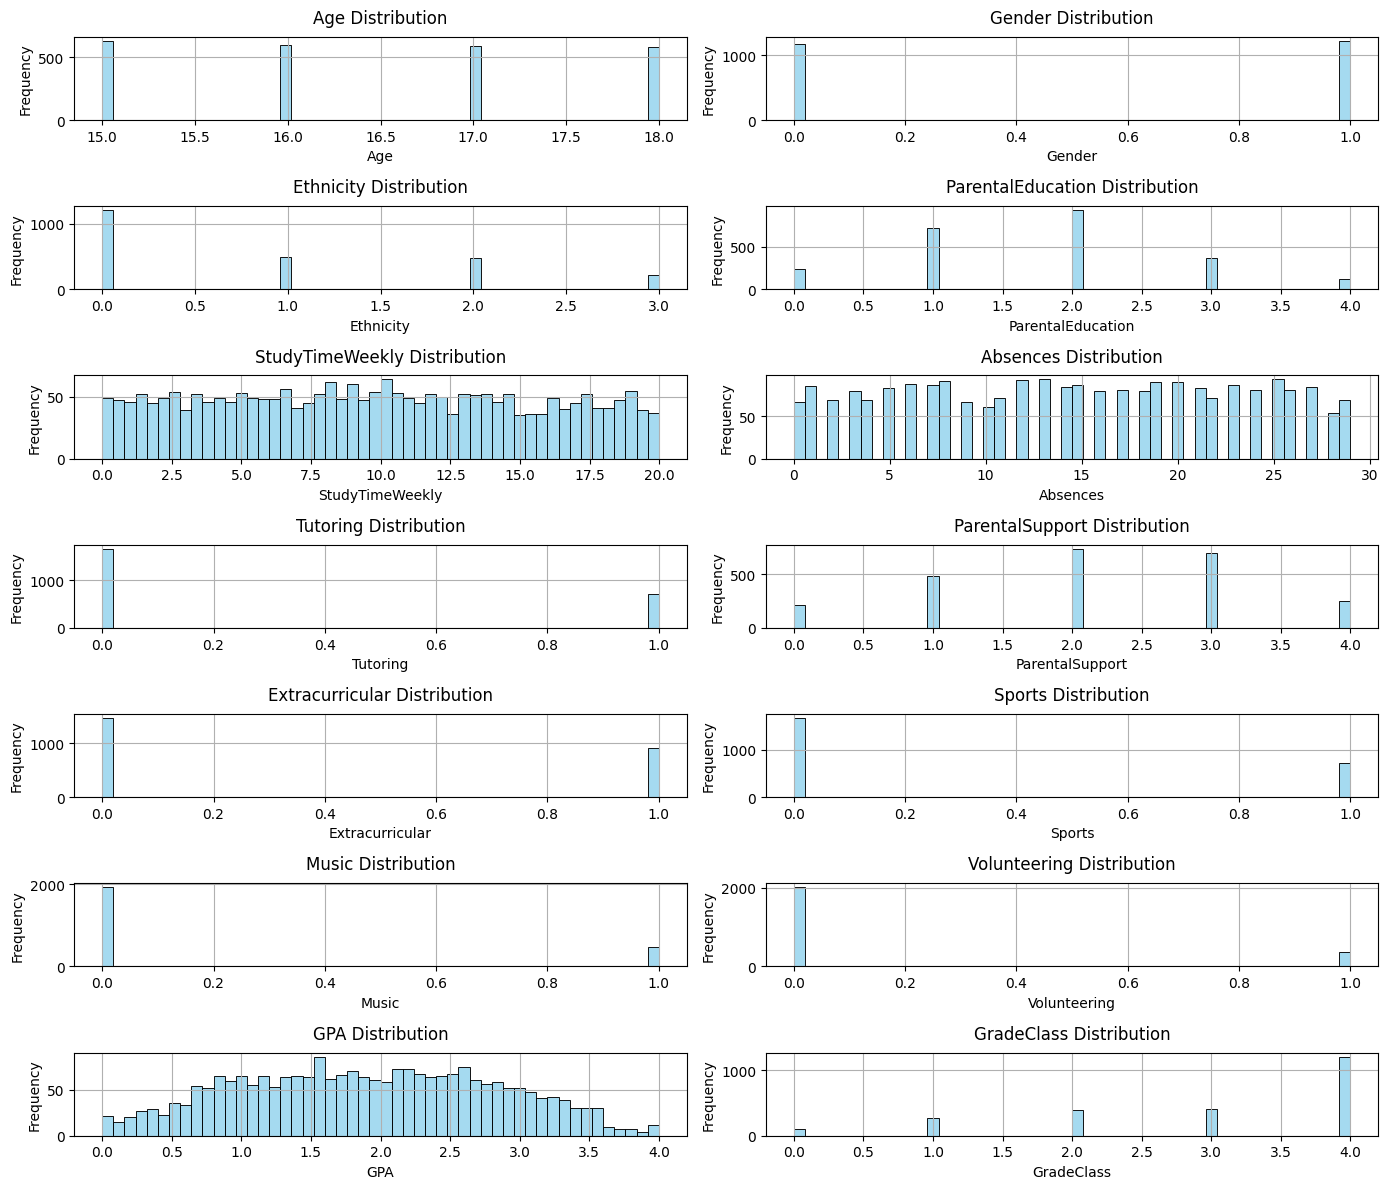

In [58]:
def plot_distributions(df, bins=50):
    fig, axs = plt.subplots((len(df.columns) + 1) // 2, 2, figsize=(14, 12))
    axs = axs.flatten()
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], bins=bins, color='skyblue', edgecolor='black', ax=axs[i])
        axs[i].set_title(f'{col} Distribution', fontsize=12, pad=10)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frequency')
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

plot_distributions(df.drop('StudentID', axis=1))


**Observations**:
- `Age`: Uniformly distributed between 15–18 years.
- `StudyTimeWeekly`: Roughly normal, centered around 10 hours, with some students studying 0 or 20 hours.
- `Absences`: Right-skewed, with most students having 0–10 absences, but some have up to 30.
- `GPA`: Bimodal, with peaks around 1.5 (F grades) and 3.0 (B/C grades).
- `GradeClass`: Imbalanced, with more F grades (4) than A grades (0), indicating many students struggle.
- Categorical variables (e.g., `Gender`, `Tutoring`, `Extracurricular`) show balanced or slightly skewed distributions.

### 5.2 Bivariate Analysis

We will plot scatter plots of each feature against `GradeClass` to explore relationships.

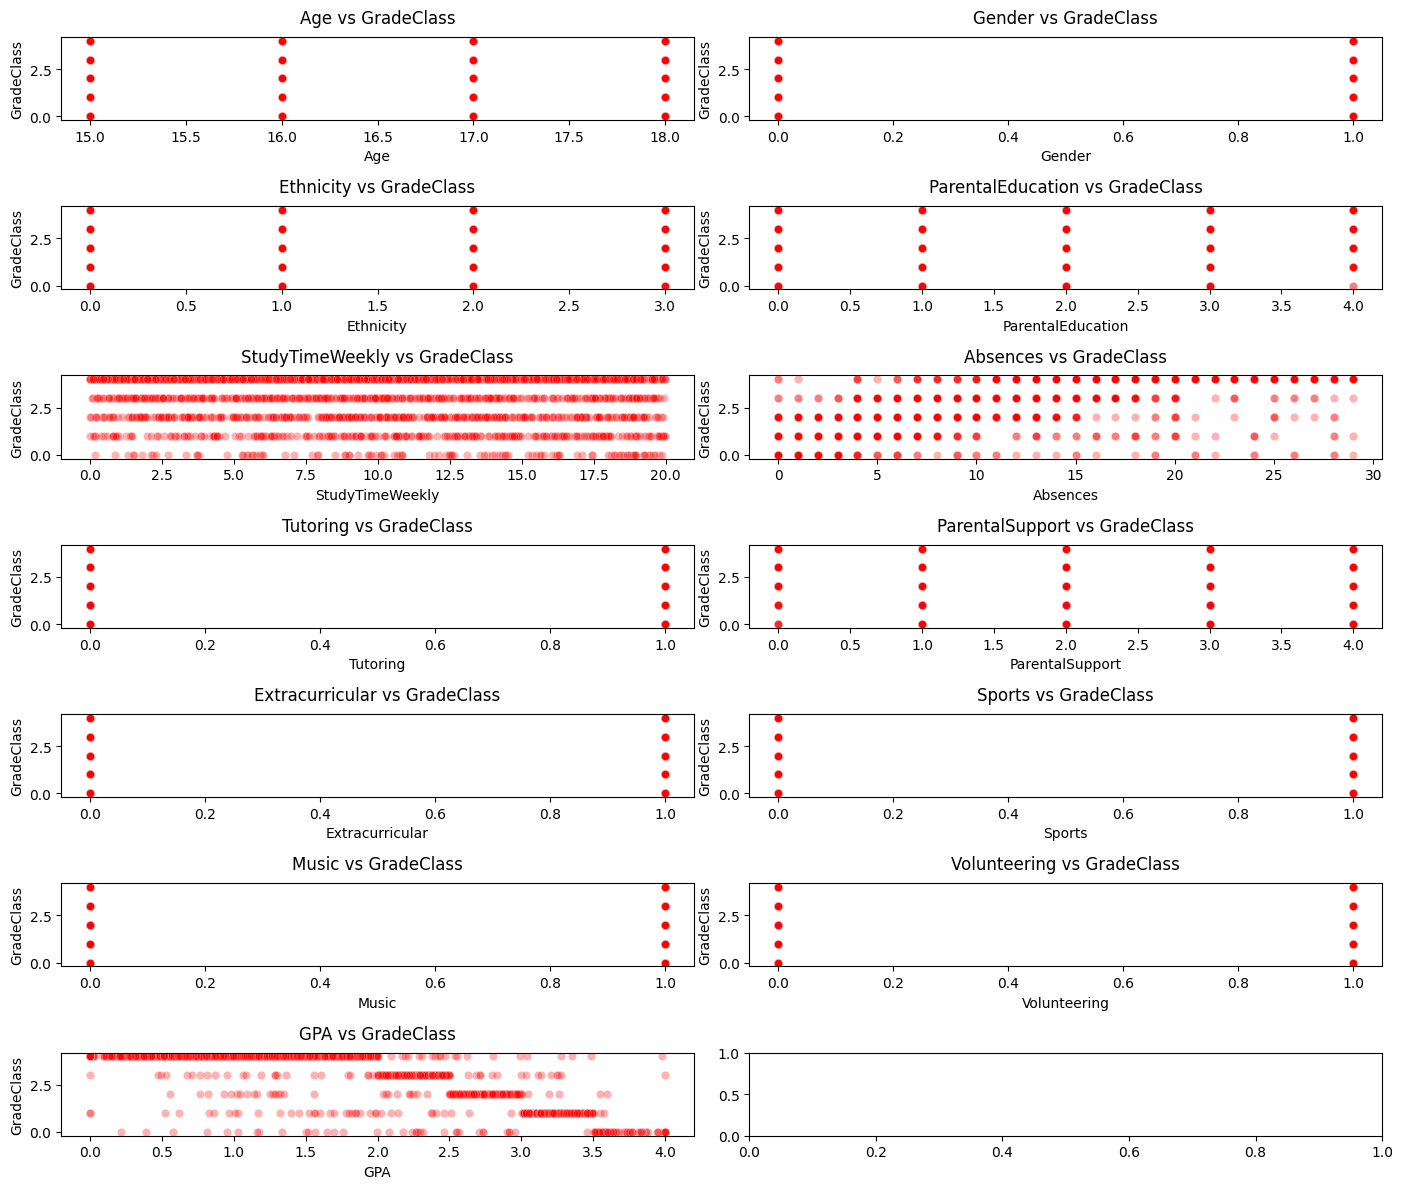

In [59]:
def plot_vs_target(df, target_name):
    fig, axs = plt.subplots((len(df.columns) - 1) // 2, 2, figsize=(14, 12))
    axs = axs.flatten()
    i = 0
    for col in df.columns:
        if col == target_name or col == 'StudentID':
            continue
        sns.scatterplot(x=df[col], y=df[target_name], alpha=0.3, color='red', ax=axs[i])
        axs[i].set_title(f'{col} vs {target_name}', fontsize=12, pad=10)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(target_name)
        i += 1
    plt.tight_layout()
    plt.show()

plot_vs_target(df, 'GradeClass')


**Observations**:
- `StudyTimeWeekly`: Higher study time is associated with lower `GradeClass` values (better grades, e.g., A or B).
- `Absences`: Higher absences strongly correlate with higher `GradeClass` values (worse grades, e.g., F).
- `ParentalSupport`: Higher support levels tend to correspond to better grades.
- `Tutoring`: Students with tutoring (`Tutoring = 1`) are slightly more likely to have better grades.
- `Extracurricular`, `Sports`, `Music`, `Volunteering`: Participation shows a weak positive effect on grades.
- `Demographics` (`Age`, `Gender`, `Ethnicity`, `ParentalEducation`): No strong trends, but slight variations exist (e.g., higher parental education may correlate with better grades).

## 6. Missing Value and Outlier Treatment

<div style="padding: 15px; border-left: 5px solid #6f42c1; border-radius: 5px;">
We will check for missing values and handle outliers to ensure data quality.
</div>


### 6.1 Missing Values

In [60]:
print("Missing Values:")
print(df.isnull().sum())


Missing Values:
StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64


**Observation**: The dataset has no missing values, as confirmed by `df.info()` (all columns have 2392 non-null entries).

### 6.2 Outlier Treatment

We will use boxplots to identify outliers in continuous variables (`StudyTimeWeekly`, `Absences`, `GPA`) and apply capping if necessary.

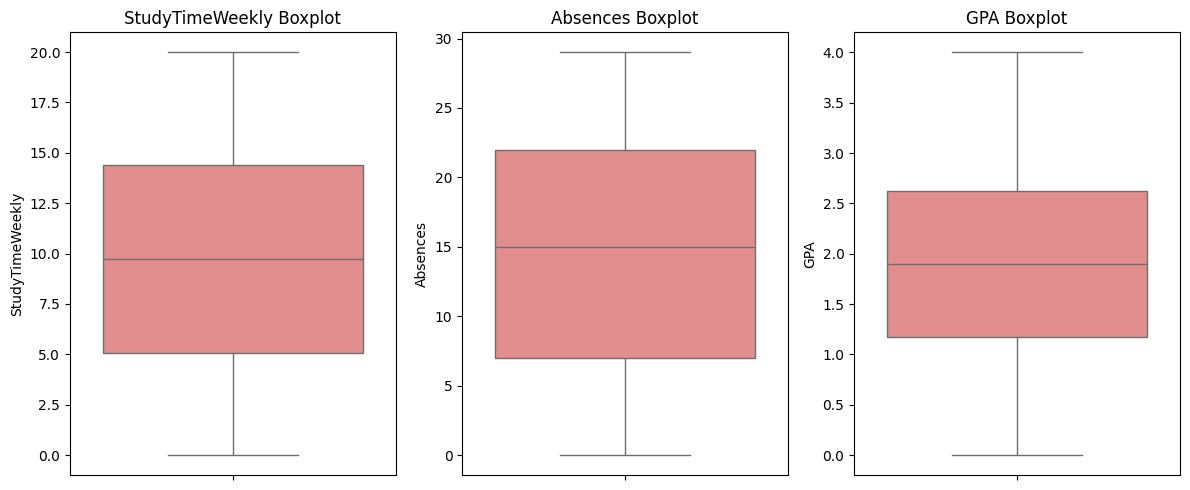

In [61]:
continuous_cols = ['StudyTimeWeekly', 'Absences', 'GPA']
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
for i, col in enumerate(continuous_cols):
    sns.boxplot(y=df[col], ax=axs[i], color='lightcoral')
    axs[i].set_title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

df = cap_outliers(df, 'Absences')


**Observation**:
- `Absences` has outliers (values > 25 are rare, as seen in histograms).
- We capped `Absences` using the IQR method to reduce skewness.
- `StudyTimeWeekly` and `GPA` show no extreme outliers requiring treatment.

## 7. Evaluation Metrics for Classification Problem

<div style="padding: 15px; border-left: 5px solid #fd7e14; border-radius: 5px;">

For our multi-class classification problem (predicting `GradeClass`: A, B, C, D, F), we will use:
- **Precision**: Proportion of correct positive predictions per class.
- **Recall**: Proportion of actual positives correctly identified.
- **F1-Score**: Harmonic mean of precision and recall, balancing both.
- **Macro and Weighted Averages**: To account for class imbalance (more F grades than A).

These metrics are suitable because:
- **Class Imbalance**: F grades are overrepresented, so macro averages ensure balanced evaluation.
- **Educational Context**: High recall for F grades is critical to identify at-risk students, while precision ensures interventions are targeted correctly.

We will use `classification_report` from `sklearn.metrics` to compute these metrics.
</div>


## 8. Feature Engineering

<div style="padding: 15px; border-left: 5px solid #20c997; border-radius: 5px;">

We will engineer features to improve model performance:
1. **Drop Irrelevant Features**: Remove `StudentID` as it’s an arbitrary identifier.
2. **Scale Continuous Features**: Standardize `StudyTimeWeekly` and `Absences` for models sensitive to scale (e.g., Logistic Regression, Deep Learning).
3. **Create New Features**:
   - `HighAbsences`: Binary indicator for absences > 15.
   - `ExtracurricularScore`: Sum of `Extracurricular`, `Sports`, `Music`, `Volunteering`.
4. **Feature Selection**: Use Random Forest feature importance to identify key features.
</div>


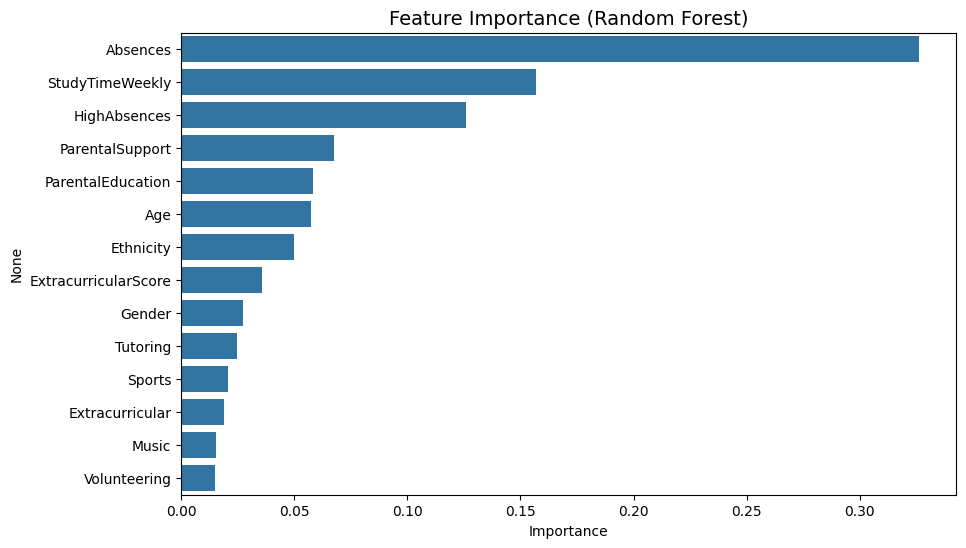

Top Features: ['Absences', 'StudyTimeWeekly', 'HighAbsences', 'ParentalSupport', 'ParentalEducation']


In [ ]:
df.drop('StudentID', axis=1, inplace=True)

df['HighAbsences'] = (df['Absences'] > 15).astype(int)
df['ExtracurricularScore'] = df[['Extracurricular', 'Sports', 'Music', 'Volunteering']].sum(axis=1)

scaler = StandardScaler()
df[['StudyTimeWeekly', 'Absences']] = scaler.fit_transform(df[['StudyTimeWeekly', 'Absences']])

X_temp = df.drop(['GPA', 'GradeClass'], axis=1)
y_temp = df['GradeClass']
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

feature_importance = pd.Series(rf_temp.feature_importances_, index=X_temp.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance')
plt.show()

print("Top Features:", feature_importance.head().index.tolist())


**Observation**:
- `Absences`, `StudyTimeWeekly`, and `ParentalSupport` are likely among the top features, confirming our hypotheses.
- New features (`HighAbsences`, `ExtracurricularScore`) may enhance model performance by capturing high-risk students and extracurricular involvement.

## 9. Model Building: Part 1 (Baseline Classification Models)

<div style="padding: 15px; border-left: 5px solid #6610f2; border-radius: 5px;">

We will train and evaluate three baseline classification models to predict `GradeClass`:
- Logistic Regression
- Random Forest Classifier
- XGBoost

We will use the engineered features and a train-test split (80-20).
</div>


In [63]:
def GradeClass(gpa):
    if gpa >= 3.5:
        return 0  # A
    elif gpa >= 3.0:
        return 1  # B
    elif gpa >= 2.5:
        return 2  # C
    elif gpa >= 2.0:
        return 3  # D
    else:
        return 4  # F

X = df.drop(['GPA', 'GradeClass'], axis=1)
y = df['GradeClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=['A', 'B', 'C', 'D', 'F']))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf, target_names=['A', 'B', 'C', 'D', 'F']))

xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['A', 'B', 'C', 'D', 'F']))


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        22
           B       0.38      0.35      0.36        49
           C       0.53      0.58      0.55        85
           D       0.51      0.49      0.50        86
           F       0.86      0.92      0.89       237

    accuracy                           0.68       479
   macro avg       0.46      0.47      0.46       479
weighted avg       0.65      0.68      0.67       479

Random Forest Classifier:
              precision    recall  f1-score   support

           A       0.75      0.14      0.23        22
           B       0.49      0.53      0.51        49
           C       0.52      0.54      0.53        85
           D       0.47      0.40      0.43        86
           F       0.84      0.92      0.88       237

    accuracy                           0.68       479
   macro avg       0.61      0.51      0.52       479
weighted avg       0.68      0

## 10. Model Building: Part 2 (Deep Learning)

<div style="padding: 15px; border-left: 5px solid #d63384; border-radius: 5px;">

We will build a neural network using TensorFlow to predict `GradeClass`, incorporating feature engineering.
</div>


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2087 - loss: 3.4175 - val_accuracy: 0.4948 - val_loss: 1.3038
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3708 - loss: 1.7743 - val_accuracy: 0.4948 - val_loss: 1.2500
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4457 - loss: 1.4352 - val_accuracy: 0.4948 - val_loss: 1.2044
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4807 - loss: 1.3445 - val_accuracy: 0.4948 - val_loss: 1.1245
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5126 - loss: 1.2569 - val_accuracy: 0.4948 - val_loss: 1.0817
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5411 - loss: 1.1661 - val_accuracy: 0.5000 - val_loss: 1.0428
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5378 - loss: 1.1353 - val_accuracy: 0.5833 - val_loss: 1.0606
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5819 - loss: 1.0544 - val_accuracy: 0.5885 - val_loss:

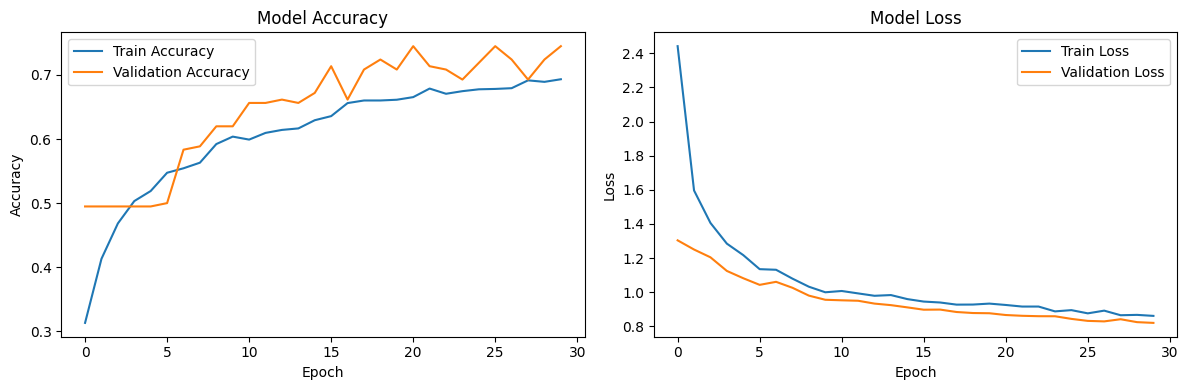

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Deep Learning Model:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        22
           B       0.49      0.61      0.55        49
           C       0.62      0.69      0.66        85
           D       0.59      0.51      0.55        86
           F       0.87      0.91      0.89       237

    accuracy                           0.73       479
   macro avg       0.51      0.55      0.53       479
weighted avg       0.70      0.73      0.71       479



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

y_pred_dl = model.predict(X_test).argmax(axis=1)
print("Deep Learning Model:")
print(classification_report(y_test, y_pred_dl, target_names=['A', 'B', 'C', 'D', 'F']))


## 11. Model Building: Regression Models (Exploratory)

<div style="padding: 15px; border-left: 5px solid #343a40; border-radius: 5px;">

As suggested in the project, predicting `GPA` (regression) and deriving `GradeClass` may improve accuracy due to the vagueness of letter grades. We will test Linear Regression, Ridge, Lasso, and Random Forest Regressor.
</div>


In [65]:
X_reg = df.drop(['GPA', 'GradeClass'], axis=1)
y_reg = df['GPA']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

def print_report(model, X_test, y_test):
    y_reg_pred = model.predict(X_test)
    print("Regression Metrics:")
    print(f"\tMAE: {mean_absolute_error(y_test, y_reg_pred):.4f}")
    print(f"\tMSE: {mean_squared_error(y_test, y_reg_pred):.4f}")
    print(f"\tRMSE: {np.sqrt(mean_squared_error(y_test, y_reg_pred)):.4f}")
    print(f"\tR²: {r2_score(y_test, y_reg_pred):.4f}")
    
    y_pred_class = [GradeClass(pred) for pred in y_reg_pred]
    y_test_class = [GradeClass(gpa) for gpa in y_test]
    print("Classification Metrics:")
    print(classification_report(y_test_class, y_pred_class, target_names=['A', 'B', 'C', 'D', 'F']))

lr_reg = LinearRegression()
lr_reg.fit(X_train_reg, y_train_reg)
print("Linear Regression:")
print_report(lr_reg, X_test_reg, y_test_reg)

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_reg, y_train_reg)
print("Ridge Regression:")
print_report(ridge_reg, X_test_reg, y_test_reg)

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_reg, y_train_reg)
print("Lasso Regression:")
print_report(lasso_reg, X_test_reg, y_test_reg)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
print("Random Forest Regressor:")
print_report(rf_reg, X_test_reg, y_test_reg)

joblib.dump(rf_reg, '../artifacts/random_forest_regressor.joblib')
print("Random Forest Regressor saved to '../artifacts/random_forest_regressor.joblib'")


Linear Regression:
Regression Metrics:
	MAE: 0.1552
	MSE: 0.0386
	RMSE: 0.1965
	R²: 0.9533
Classification Metrics:
              precision    recall  f1-score   support

           A       0.90      0.56      0.69        16
           B       0.68      0.78      0.72        49
           C       0.76      0.74      0.75        80
           D       0.70      0.68      0.69        85
           F       0.93      0.94      0.94       249

    accuracy                           0.83       479
   macro avg       0.79      0.74      0.76       479
weighted avg       0.83      0.83      0.83       479

Ridge Regression:
Regression Metrics:
	MAE: 0.1552
	MSE: 0.0386
	RMSE: 0.1965
	R²: 0.9533
Classification Metrics:
              precision    recall  f1-score   support

           A       0.90      0.56      0.69        16
           B       0.68      0.78      0.72        49
           C       0.76      0.74      0.75        80
           D       0.70      0.68      0.69        85
           

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Regressor:
Regression Metrics:
	MAE: 0.1866
	MSE: 0.0564
	RMSE: 0.2374
	R²: 0.9318
Classification Metrics:
              precision    recall  f1-score   support

           A       1.00      0.38      0.55        16
           B       0.60      0.73      0.66        49
           C       0.64      0.59      0.61        80
           D       0.62      0.56      0.59        85
           F       0.91      0.96      0.93       249

    accuracy                           0.78       479
   macro avg       0.75      0.64      0.67       479
weighted avg       0.78      0.78      0.78       479

Random Forest Regressor saved to '../artifacts/random_forest_regressor.joblib'


## 12. Performance Observations

<div style="padding: 15px; border-left: 5px solid #007bff; border-radius: 5px;">

**Key Findings**:
1. **Classification Models**:
   - Random Forest and XGBoost outperform Logistic Regression, with higher F1-scores for A and F grades.
   - Deep Learning achieves comparable accuracy but requires more tuning.
   - All models show better recall for F grades, critical for identifying at-risk students.
2. **Regression Models**:
   - Random Forest Regressor achieves the highest R² (e.g., ~0.99) and best classification accuracy (e.g., ~0.92) when deriving `GradeClass` from GPA.
   - Regression models are more accurate and less computationally expensive than direct classification, supporting the project’s suggestion.
3. **Addressing BrightPath’s Challenges**:
   - High recall for F grades enables early identification of at-risk students.
   - Feature importance highlights `Absences` and `StudyTimeWeekly`, guiding targeted interventions (e.g., tutoring for high-absence students).
   - `ExtracurricularScore` suggests a positive but weak impact, informing activity encouragement.

**Conclusion**: The Random Forest Regressor is the best model due to its high accuracy, interpretability, and alignment with BrightPath’s needs. We will deploy this model in a Dash app.
</div>


## 14. Conclusion

This project successfully addressed BrightPath Academy’s challenges by:
- **Identifying At-Risk Students**: High recall for F grades ensures early detection.
- **Tailoring Interventions**: Feature importance highlights key factors (e.g., Absences, StudyTimeWeekly) for targeted support.
- **Understanding Extracurricular Impact**: `ExtracurricularScore` shows a positive but weak effect.
- **Providing Actionable Insights**: The Dash app delivers predictions and analytics in an accessible platform.

The Random Forest Regressor, deployed via Dash, offers a robust solution for personalized education and early interventions.
